In [2]:
import matplotlib.pyplot as plt
from fenics import *
import numpy as np
plt.rc("text", usetex=False) 
plt.rc("mathtext", fontset="cm")
plt.rc("font", family="serif", serif="cmr10", size=12)
plt.rc("axes.formatter", use_mathtext = True)

Nx = 64
g = 50.0
D_T = 0.1
D_R = 1.0
v0 = 5.0
a = 1.0
n = 1.0
D = 1.0
Ll = 0.1

In [3]:
class PeriodicBoundaryX(SubDomain):
    def inside(self, x, on_boundary):
        return bool((near(x[0],0) or near(x[0],1)) and (on_boundary))

    def map(self, x, y):
        y[0] = x[0] - 1.0

class PeriodicBoundary(SubDomain):
    def inside(self, x, on_boundary):
                return bool((near(x[0], 0) or near(x[1], 0)) and 
                (not ((near(x[0], 0) and near(x[1], 1)) or 
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1.
            y[1] = x[1] - 1.
        elif near(x[0], 1):
            y[0] = x[0] - 1.
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1.


pbX = PeriodicBoundaryX()
pb = PeriodicBoundary()

In [4]:
mesh = UnitSquareMesh(Nx, Nx)
mesh1D = UnitIntervalMesh(Nx)
V1D = FunctionSpace(mesh1D, 'CG', 1, constrained_domain=pbX)
Q = FiniteElement("CG", triangle, 1)
LM = FiniteElement("Real", triangle, 0)
V = FunctionSpace(mesh, Q, constrained_domain=pb)
M = FunctionSpace(mesh, MixedElement([Q, LM]), constrained_domain=pb)

dx = Measure('dx', mesh)
dx1 = Measure('dx',mesh1D)

dxc = Expression("sin(2*pi*x[0])",degree=2)
costh = Expression("cos(2*pi*x[1])",degree=2)
sinth = Expression("sin(2*pi*x[1])",degree=2)
xl = Expression("x[0]+Ll*cos(2*pi*x[1])",Ll=Ll,degree=2)
dxcl = Expression("sin(2*pi*xl)",xl=xl,degree=2)

Solving nonlinear variational problem.
  0 SNES Function norm 9.999999999563e-01 
  1 SNES Function norm 9.058938146459e+01 
  2 SNES Function norm 1.226378259850e+01 
  3 SNES Function norm 1.489974672355e+00 
  4 SNES Function norm 3.998461111978e-01 
  5 SNES Function norm 3.260923929069e+00 
  6 SNES Function norm 4.779785402553e-02 
  7 SNES Function norm 2.220110028692e-02 
  8 SNES Function norm 8.641953661239e-03 
  9 SNES Function norm 4.737383120901e-03 
 10 SNES Function norm 2.275179452933e-03 
 11 SNES Function norm 1.061847996927e-03 
 12 SNES Function norm 5.085250995382e-04 
 13 SNES Function norm 1.994605563635e-04 
 14 SNES Function norm 7.151291436730e-05 
 15 SNES Function norm 1.503629916390e-05 
 16 SNES Function norm 6.023770411969e-07 
 17 SNES Function norm 1.669381878964e-08 
 18 SNES Function norm 6.291244581103e-09 
 19 SNES Function norm 2.325892490915e-09 
 20 SNES Function norm 8.534101751611e-10 
  PETSc SNES solver converged in 20 iterations with conver

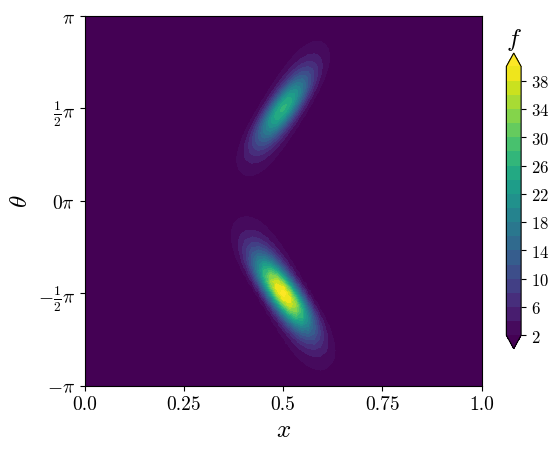

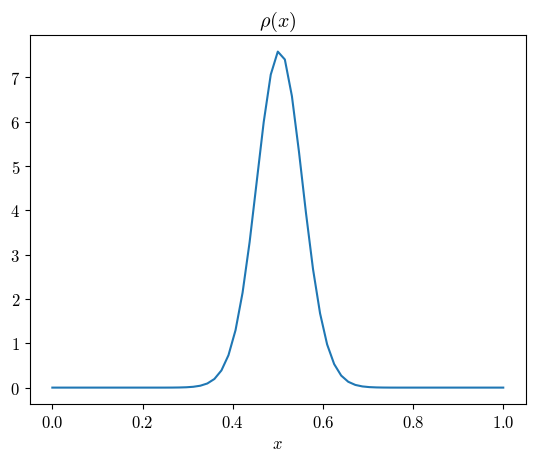

Solving nonlinear variational problem.
mass  = 1.00e+00
7.502267767250066e-11
  0 SNES Function norm 1.548925006203e+00 
  1 SNES Function norm 3.138112964252e-01 
  2 SNES Function norm 1.475619170434e-01 
  3 SNES Function norm 5.408304951192e-02 
  4 SNES Function norm 1.559535119693e-02 
  5 SNES Function norm 3.919500840975e-03 
  6 SNES Function norm 1.480485972673e-04 
  7 SNES Function norm 1.786892203406e-07 
  8 SNES Function norm 0.000000000000e+00 
  PETSc SNES solver converged in 8 iterations with convergence reason CONVERGED_FNORM_ABS.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.750e-01 (tol = 1.000e-12) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.021e-13 (tol = 1.000e-12) r (rel) = 7.349e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
tot res = 2.8977e-12


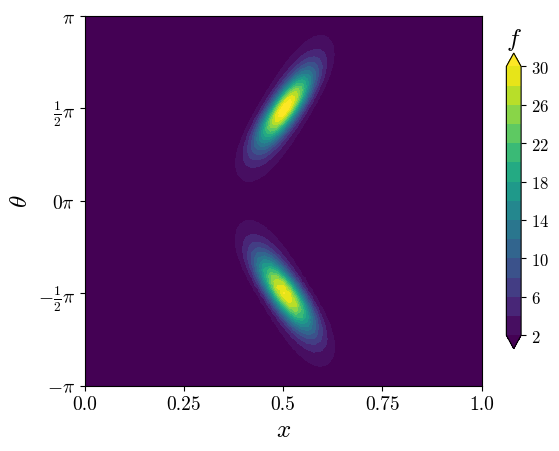

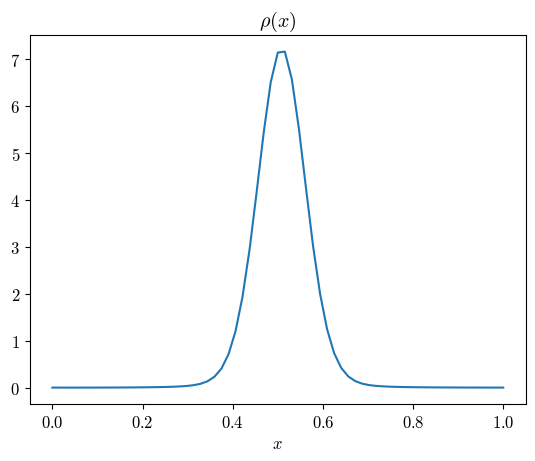

In [5]:

res_tot = 50
num_loop = 0
w = Function(M)
while res_tot > 1e-11:
    f, lm = split(w)
    wt = TestFunction(M)
    v, lmt = split(wt)
    mc = 1.0
    wt = TrialFunction(M)

    #for Pe=g=10 used 1e5 for LM
    lbfunc = Function(M)
    lbfunc.interpolate(Expression(("0.0","-1e5"),degree=2))
    ubfunc = Function(M)
    ubfunc.interpolate(Expression(("1e4","1e5"),degree=2))

    B = D_T*inner(grad(f),grad(v))*dx - \
        v0*costh*f*grad(v)[0]*dx + \
        g*sinth*dxcl*f*grad(v)[1]*dx + \
        lm*v*dx + lmt*f*dx - lmt*mc*dx


    J  = derivative(B, w, wt)
    problem = NonlinearVariationalProblem(B,w,J=J)
    problem.set_bounds(lbfunc,ubfunc)
    solver  = NonlinearVariationalSolver(problem)
    snes_solver_parameters = {"nonlinear_solver": "snes",
                            "snes_solver": {"linear_solver": "lu",
                                            #"absolute_tolerance": 1e-6,
                                            "maximum_iterations": 100
                            }}
    solver.parameters.update(snes_solver_parameters)
    solver.solve()

    f,lm=w.split()

    print("mass  = {:.2e}".format(assemble(f*dx)))
    print(lm((0,0)))

    rho_num=128
    thetas = np.linspace(0,0.99999,rho_num)
    xs = np.linspace(0.0,0.99999,rho_num)
    rhos = np.zeros(rho_num)

    for i in range(len(xs)):
        fs = [f((xs[i],j)) for j in thetas]
        rhos[i] = np.mean(fs)

    class rho_inter_1D(UserExpression):
        def eval(self, values, x):
            values[0] = rhos[int(np.floor((rho_num-1)*x[0]))]
        def value_shape(self):
            return ()

    rho1D = rho_inter_1D()
    rho1D = project(rho1D,V1D)  

    c = Function(V1D)
    wc = TestFunction(V1D)
    wct = TrialFunction(V1D)       

    Bc = D*grad(c)[0]*grad(wc)[0]*dx1+a*c*wc*dx1-n*rho1D*wc*dx1

    Jc  = derivative(Bc, c, wct) 

    problemc = NonlinearVariationalProblem(Bc,c,J=Jc)
    solverc  = NonlinearVariationalSolver(problemc)
    prmc = solverc.parameters
    prmc['newton_solver']['absolute_tolerance'] = 1e-12
    prmc['newton_solver']['maximum_iterations'] = 100
    solverc.solve()

    class c_inter_2D2(UserExpression):
        def eval(self, values, x):
            t = np.mod(x[0]+Ll*cos(2*pi*x[1]),1.0)
            values[0] = c((t))
        def value_shape(self):
            return ()

    c2D = c_inter_2D2()
    c2D = interpolate(c2D,V)
    dxcl = grad(c2D)[0]

    res1 = assemble(B)
    res1max = max(abs(res1.max()),abs(res1.min()))
    resc = assemble(Bc)
    rescmax = max(abs(resc.max()),abs(resc.min()))
    print("tot res = {:.4e}".format(res1max+rescmax))

    plot_num = 200
    plot_thetas = np.linspace(0.0,0.99999,plot_num)
    plot_xs = np.linspace(0.0,0.99999,plot_num)
    xx, yy = np.meshgrid(plot_xs,plot_thetas)
    fs_end = np.zeros((plot_num,plot_num))
    for i in range(plot_num):
        for j in range(plot_num):
            fs_end[j,i]=f((plot_xs[i],np.mod(plot_thetas[j]+0.5,1)))

    plt.contourf(xx,yy,fs_end,levels=20,extend="both")
    plt.yticks(ticks=np.linspace(0,0.99999,5),labels=[r"$-\pi$",r"$-\frac{1}{2}\pi$",r"$0\pi$",r"$\frac{1}{2}\pi$",r"$\pi$"],fontsize=14)
    plt.xticks(ticks=np.linspace(0,0.99999,5),labels=np.linspace(0,1.0,5),fontsize=14)

    cb = plt.colorbar(shrink=0.8)
    cb.ax.set_title(r'$f$',fontsize=18)

    plt.ylabel(r'$\theta$',fontsize=18)
    plt.xlabel(r'$x$',fontsize=18)
    plt.savefig("fxth_D_T={:.2f}_D_R={:.2f}_v_0={:.2f}_gam={:.2f}_lam={:.2f}.eps".format(D_T,D_R,v0,g,Ll))
    plt.show()
    plt.close()
    plot(rho1D)
    plt.title(r'$\rho(x)$')
    plt.xlabel(r'$x$')
    plt.savefig("rho_D_T={:.2f}_D_R={:.2f}_v_0={:.2f}_gam={:.2f}_lam={:.2f}.eps".format(D_T,D_R,v0,g,Ll))
    plt.show()
    plt.close()


    res_tot = res1max+rescmax
    num_loop += 1

In [11]:
Ll = 0.0

mesh = UnitSquareMesh(Nx, Nx)
mesh1D = UnitIntervalMesh(Nx)
V1D = FunctionSpace(mesh1D, 'CG', 1, constrained_domain=pbX)
Q = FiniteElement("CG", triangle, 1)
LM = FiniteElement("Real", triangle, 0)
V = FunctionSpace(mesh, Q, constrained_domain=pb)
M = FunctionSpace(mesh, MixedElement([Q, LM]), constrained_domain=pb)

dx = Measure('dx', mesh)
dx1 = Measure('dx',mesh1D)

dxc = Expression("sin(2*pi*x[0])",degree=2)
costh = Expression("cos(2*pi*x[1])",degree=2)
sinth = Expression("sin(2*pi*x[1])",degree=2)
xl = Expression("x[0]+Ll*cos(2*pi*x[1])",Ll=Ll,degree=2)
dxcl = Expression("sin(2*pi*xl)",xl=xl,degree=2)

Solving nonlinear variational problem.
mass  = 1.00e+00
-4.751962151476976e-12
  0 SNES Function norm 9.999999999563e-01 
  1 SNES Function norm 9.057028194365e+01 
  2 SNES Function norm 1.219991430796e+01 
  3 SNES Function norm 1.584706413563e+00 
  4 SNES Function norm 1.112342166783e-02 
  5 SNES Function norm 4.175758325452e-07 
  6 SNES Function norm 0.000000000000e+00 
  PETSc SNES solver converged in 6 iterations with convergence reason CONVERGED_FNORM_ABS.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.340e-01 (tol = 1.000e-12) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.122e-13 (tol = 1.000e-12) r (rel) = 9.070e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
tot res = 2.8948e-12


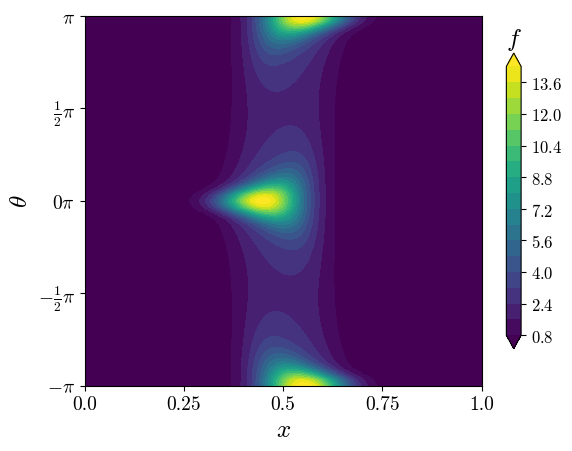

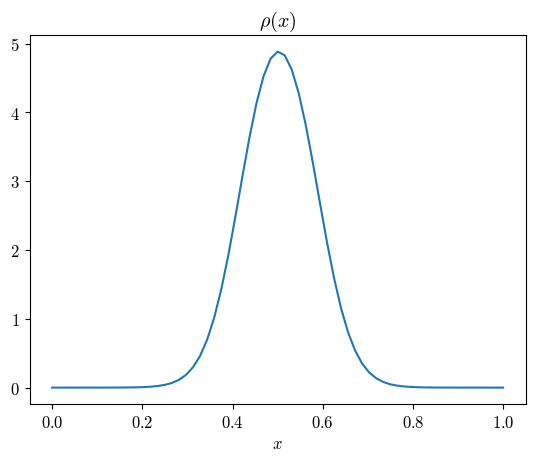

In [12]:

res_tot = 50
num_loop = 0
w = Function(M)
while res_tot > 1e-11:
    f, lm = split(w)
    wt = TestFunction(M)
    v, lmt = split(wt)
    mc = 1.0
    wt = TrialFunction(M)

    #for Pe=g=10 used 1e5 for LM
    lbfunc = Function(M)
    lbfunc.interpolate(Expression(("0.0","-1e5"),degree=2))
    ubfunc = Function(M)
    ubfunc.interpolate(Expression(("1e4","1e5"),degree=2))

    B = D_T*inner(grad(f),grad(v))*dx - \
        v0*costh*f*grad(v)[0]*dx + \
        g*sinth*dxcl*f*grad(v)[1]*dx + \
        lm*v*dx + lmt*f*dx - lmt*mc*dx


    J  = derivative(B, w, wt)
    problem = NonlinearVariationalProblem(B,w,J=J)
    problem.set_bounds(lbfunc,ubfunc)
    solver  = NonlinearVariationalSolver(problem)
    snes_solver_parameters = {"nonlinear_solver": "snes",
                            "snes_solver": {"linear_solver": "lu",
                                            #"absolute_tolerance": 1e-6,
                                            "maximum_iterations": 100
                            }}
    solver.parameters.update(snes_solver_parameters)
    solver.solve()

    f,lm=w.split()

    print("mass  = {:.2e}".format(assemble(f*dx)))
    print(lm((0,0)))

    rho_num=128
    thetas = np.linspace(0,0.99999,rho_num)
    xs = np.linspace(0.0,0.99999,rho_num)
    rhos = np.zeros(rho_num)

    for i in range(len(xs)):
        fs = [f((xs[i],j)) for j in thetas]
        rhos[i] = np.mean(fs)

    class rho_inter_1D(UserExpression):
        def eval(self, values, x):
            values[0] = rhos[int(np.floor((rho_num-1)*x[0]))]
        def value_shape(self):
            return ()

    rho1D = rho_inter_1D()
    rho1D = project(rho1D,V1D)  

    c = Function(V1D)
    wc = TestFunction(V1D)
    wct = TrialFunction(V1D)       

    Bc = D*grad(c)[0]*grad(wc)[0]*dx1+a*c*wc*dx1-n*rho1D*wc*dx1

    Jc  = derivative(Bc, c, wct) 

    problemc = NonlinearVariationalProblem(Bc,c,J=Jc)
    solverc  = NonlinearVariationalSolver(problemc)
    prmc = solverc.parameters
    prmc['newton_solver']['absolute_tolerance'] = 1e-12
    prmc['newton_solver']['maximum_iterations'] = 100
    solverc.solve()

    class c_inter_2D2(UserExpression):
        def eval(self, values, x):
            t = np.mod(x[0]+Ll*cos(2*pi*x[1]),1.0)
            values[0] = c((t))
        def value_shape(self):
            return ()

    c2D = c_inter_2D2()
    c2D = interpolate(c2D,V)
    dxcl = grad(c2D)[0]

    res1 = assemble(B)
    res1max = max(abs(res1.max()),abs(res1.min()))
    resc = assemble(Bc)
    rescmax = max(abs(resc.max()),abs(resc.min()))
    print("tot res = {:.4e}".format(res1max+rescmax))

    plot_num = 200
    plot_thetas = np.linspace(0.0,0.99999,plot_num)
    plot_xs = np.linspace(0.0,0.99999,plot_num)
    xx, yy = np.meshgrid(plot_xs,plot_thetas)
    fs_end = np.zeros((plot_num,plot_num))
    for i in range(plot_num):
        for j in range(plot_num):
            fs_end[j,i]=f((plot_xs[i],np.mod(plot_thetas[j]+0.5,1)))

    plt.contourf(xx,yy,fs_end,levels=20,extend="both")
    plt.yticks(ticks=np.linspace(0,0.99999,5),labels=[r"$-\pi$",r"$-\frac{1}{2}\pi$",r"$0\pi$",r"$\frac{1}{2}\pi$",r"$\pi$"],fontsize=14)
    plt.xticks(ticks=np.linspace(0,0.99999,5),labels=np.linspace(0,1.0,5),fontsize=14)

    cb = plt.colorbar(shrink=0.8)
    cb.ax.set_title(r'$f$',fontsize=18)

    plt.ylabel(r'$\theta$',fontsize=18)
    plt.xlabel(r'$x$',fontsize=18)
    plt.savefig("fxth_D_T={:.2f}_D_R={:.2f}_v_0={:.2f}_gam={:.2f}_lam={:.2f}.eps".format(D_T,D_R,v0,g,Ll))
    plt.show()
    plt.close()
    plot(rho1D)
    plt.title(r'$\rho(x)$')
    plt.xlabel(r'$x$')
    plt.savefig("rho_D_T={:.2f}_D_R={:.2f}_v_0={:.2f}_gam={:.2f}_lam={:.2f}.eps".format(D_T,D_R,v0,g,Ll))
    plt.show()
    plt.close()


    res_tot = res1max+rescmax
    num_loop += 1